In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 134.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


* **Install libraries and models**

In [2]:
!python -m pip install pyyaml==5.1
import sys,os,distutils.core
!git clone "https://github.com/facebookresearch/detectron2"
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {" ".join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0,os.path.abspath("./detectron2"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 22.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 15900 (delta 60), reused 23 (delta 23), pack-reused 15803 (from 4)
Receiving objects: 100% (15900/15900), 6.46 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (11565/11565), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os,json,cv2,random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog

* **Import The Dataset**

In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key="Bn6W2U9lbXLol8dgR3zf")
project = rf.workspace("roboflow-universe-projects").project("fire-and-smoke-segmentation")
version = project.version(6)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-and-Smoke-Segmentation-6 in coco-segmentation:: 100%|██████████| 7118/7118 [00:01<00:00, 4559.60it/s]


* **Register Dataset**

In [5]:
#/This code snippet uses the register_coco_instances function from the detectron2.data.datasets module to register your dataset with Detectron2.

#Here's a breakdown:

#from detectron2.data.datasets import register_coco_instances: This line imports the necessary function to register datasets in COCO format.
#register_coco_instances("exp_train",{},"/content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json"): This line registers the training set.
#"exp_train": This is the name you're giving to this dataset within Detectron2.
#{}: This is an empty dictionary that can be used to provide extra metadata if needed, but in this case, it's left empty.
#"/content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json": This is the path to the COCO annotation file for your training data. Detectron2 will use this file to understand the structure and annotations of your dataset.
#register_coco_instances("exp_test",{},"/content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json"): This line does the same for your test set, naming it "exp_test".
#register_coco_instances("exp_valid",{},"/content/Fire-and-Smoke-Segmentation-6/valid/_annotations.coco.json"): This line registers your validation set, naming it "exp_valid".
#In essence, these lines are telling Detectron2 where to find the annotation files for your training, testing, and validation datasets, and assigning a name to each so you can refer to them later in your Detectron2 workflow
from detectron2.data.datasets import register_coco_instances
register_coco_instances("exp_train",{},"/content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json","/content/Fire-and-Smoke-Segmentation-6/train")
register_coco_instances("exp_test",{},"/content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json","/content/Fire-and-Smoke-Segmentation-6/test")
register_coco_instances("exp_valid",{},"/content/Fire-and-Smoke-Segmentation-6/valid/_annotations.coco.json","/content/Fire-and-Smoke-Segmentation-6/valid")

* **Training**

In [8]:
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASET.TRAIN = ("exp_train")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHT = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000 #MIN required 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume = True)


[07/26 15:51:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 197MB/s]                            

[07/26 15:51:43 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[07/26 15:51:43 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[07/26 15:51:43 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[07/26 15:51:52 d2.utils.events]:  eta: 0:04:21  iter: 19  total_loss: 1.604  loss_cls: 0.7646  loss_box_reg: 0.07676  loss_rpn_cls: 0.6994  loss_rpn_loc: 0.0314    time: 0.2713  last_time: 0.2656  data_time: 0.0203  last_data_time: 0.0107   lr: 4.9952e-05  max_mem: 1737M
[07/26 15:52:02 d2.utils.events]:  eta: 0:04:24  iter: 39  total_loss: 0.9572  loss_cls: 0.1799  loss_box_reg: 0.1291  loss_rpn_cls: 0.6029  loss_rpn_loc: 0.02782    time: 0.2776  last_time: 0.3108  data_time: 0.0089  last_data_time: 0.0041   lr: 9.9902e-05  max_mem: 1737M
[07/26 15:52:08 d2.utils.events]:  eta: 0:04:18  iter: 59  total_loss: 1.127  loss_cls: 0.3681  loss_box_reg: 0.3111  loss_rpn_cls: 0.4202  loss_rpn_loc: 0.01824    time: 0.2797  last_time: 0.2849  data_time: 0.0089  last_data_time: 0.0043   lr: 0.00014985  max_mem: 1737M
[07/26 15:52:14 d2.utils.events]:  eta: 0:04:13  iter: 79  total_loss: 1.147  loss_cls: 0.421  loss_box_reg: 0.4033  loss_rpn_cls: 0.2433  loss_rpn_loc: 0.02221    time: 0.2789  la

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_val2017.json'

In [10]:
cfg.MODEL_WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("exp_test")
predictor = DefaultPredictor(cfg)


[07/26 16:01:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[07/26 16:01:17 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/26 16:01:17 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


WARNING [07/26 16:20:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/26 16:20:48 d2.data.datasets.coco]: Loaded 7050 images in COCO format from /content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json


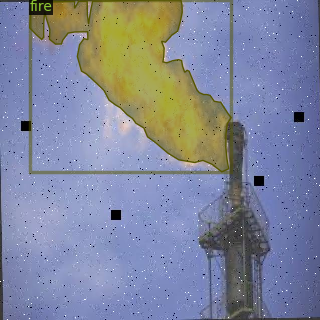

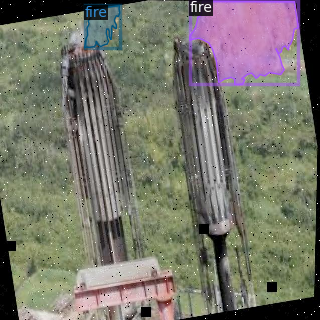

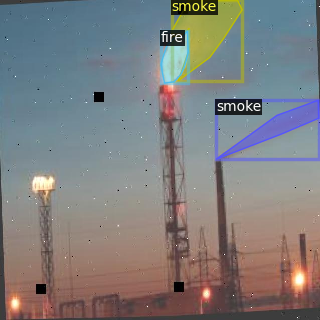

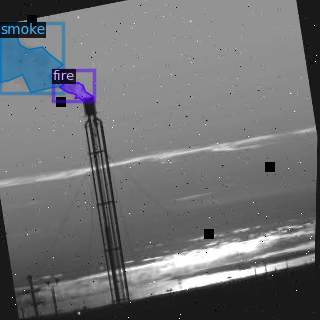

In [15]:
dataset_dicts = DatasetCatalog.get("exp_train")

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    visualizer = Visualizer(im[:, :, ::-1], MetadataCatalog.get("exp_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])